### I. Importing Libraries/Packages

In [ ]:
import numpy as np
import skimage as sk
import skimage.feature
import skimage.io as skio
import skimage.transform as sktr
import math
import os

### II. Defining Helper Functions

#### 1. split_color_channels()

This function splits the input images from the "original_data" folder into blue, green, and red channels. It should be noted that for all the images, the filter order from top to bottom is blue, green, and red (BGR). It is not in the typical order of red, green, and blue (RGB).

In [ ]:
def split_color_channels(imname):

    # Reads an image file and loads it as an array
    im = skio.imread(imname)

    # Converts image data to double
    im = sk.img_as_float(im)

    # Computes the height of each part (just 1/3 of total)
    height = np.floor(im.shape[0] / 3.0).astype(int)

    # Separates color channels (b=blue, g=green, r=red)
    b = im[:height]
    g = im[height: 2 * height]
    r = im[2 * height: 3 * height]

    return b, g, r

#### 2. crop_image()

This function crops the input images by getting rid of 15% of width and height. This is done to remove the black borders of the digitalized glass plates and lines of colors that appear after aligning.

In [ ]:
def crop_image(original_image):

    # Calculating the dimensions of the image
    image_width, image_height = original_image.shape

    # Calculating the dimensions to crop 15% of the width and height (85% remains)
    crop_width = (int)(8.5 * image_width / 10)
    remaining_width = (int)((image_width - crop_width)/2)

    crop_height = (int)(8.5 * image_height / 10)
    remaining_height = (int)((image_height - crop_height) / 2)

    # Cropping the image using array slicing
    cropped_image = original_image[remaining_width: image_width - remaining_width,
                             remaining_height: image_height - remaining_height]
    return cropped_image

#### 3. get_edges() & SSD()
* **get_edges()**: This function uses Canny edge detection algorithm to extract the edges of the images using a sigma of 3. It is later used in the pyramid_align() function.

* **SSD()**: The function calculates the Sum of Squared Differences (SSD) distance. It is later used in the get_displacement() function to score the alignment of the images and return the displacement with the best score.

In [ ]:
def get_edges(image):
    return sk.feature.canny(image, 3)

In [ ]:
# Sum of Squared Differences (SSD) distance, also known as L2 Norm
def SSD(image1, image2):
    return np.sum(np.sum((image1^image2)**2))

#### 4. Alignment & Displacement

* **horizontal_shift()**: This function shifts an image by rolling its pixels (n) along the horizontal axis.

* **vertical_shift()**: This function shifts an image by rolling its pixels (n) along the vertical axis.

* **align()**: This function uses horizontal_shift() and vertical_shift() to align an image based on the displacement vector (d).

* **get_displacement()**: This function searches over a window of [-15][15] pixels, score each one using the SSD() function, and returns the displacement with the best score.

* **pyramid_align()**: This function aligns images using an image pyramid, which represents the image at multiple scales. This is needed for the .tif images because it is expensive to search when the pixel displacement is large.

In [ ]:
def horizontal_shift(image, n):
    return np.roll(image, n, axis=1)

def vertical_shift(image, n):
    return np.roll(image, n, axis=0)

def align(image, d):
    return horizontal_shift(vertical_shift(image, d[1]), d[0])

In [ ]:
def get_displacement(image1, image2, window=15):
    x = 0
    y = 0
    min_ssd = SSD(image1, image2)

    for i in range(-window, window):
        for j in range(-window, window):
            displaced_image = align(image1, [i, j])
            new_ssd = SSD(displaced_image, image2)

            if new_ssd < min_ssd:
                x = i
                y = j
                min_ssd = new_ssd
    return [x, y]

In [ ]:
def pyramid_align(r, g, b, num_runs, displacements):

    #Base case for when there are no image pyramid levels (for the .jpg images)
    if num_runs == 0:
        print(f'Displacement[[Green], [Red]]: {displacements}')
        return np.dstack((r,g,b))

    factor = 2 ** num_runs

    # Rescaling color channels by the factor determined by the current number of runs
    new_r = get_edges(sktr.rescale(r, 1 / factor))
    new_g = get_edges(sktr.rescale(g, 1 / factor))
    new_b = get_edges(sktr.rescale(b, 1 / factor))

    # Calculates the displacement between rescaled green and blue & aligns green
    ag_d = get_displacement(new_g, new_b)
    ag = align(new_g, ag_d)

    # Calculates the displacement between rescaled red and aligned green
    ar_d = get_displacement(new_r, ag)

    # Aligns the original image using rescaled image displacement
    g = align(g, [ag_d[0] * factor, ag_d[1] * factor])
    r = align(r, [ar_d[0] * factor, ar_d[1] * factor])

    # Updating the displacement vectors and mutliplying by the factor to keep track of the original displacement

    # Green displacement
    displacements[0][0] += ag_d[0] * factor
    displacements[0][1] += ag_d[1] * factor

    # Red displacement
    displacements[1][0] += ar_d[0] * factor
    displacements[1][1] += ar_d[1] * factor


    # Recursively calling the function to go down the image pyramid
    return pyramid_align(r, g, b, num_runs-1, displacements)

### III. The Main Function: colorize()

This is the main function that calls on the helper functions to colorize all the images in the "original_data" folder. First, it splits the image into BGR color channels using the **split_color_channels()** function. Then, it crops each color channel using the **crop_image()** function. Next, it uses **pyramid_align()** to align the color channels. Lastly, it scales the final colorized image to an 8-bit image, saves it in "colorized_results" folder, and displays it along with its displacement matrix.

In [ ]:
def colorize(imname):

    # Extract the file name from the full path & prints the name of the image
    name = os.path.basename(imname)
    print(f'Image: {name}')

    b, g, r, = split_color_channels(imname)

    b = crop_image(b)
    g = crop_image(g)
    r = crop_image(r)

    # Number of levels in image pyramid
    num_runs = math.floor(math.log2(b.shape[1] / 100))

    displacements = [[0, 0], [0, 0]]
    rgb = pyramid_align(r, g, b, num_runs, displacements)

    rgb = 255 * rgb # Now scale by 255
    img = rgb.astype(np.uint8)

    # Saves each colorized image in the "colorized_results" folder
    results_dir = "/path/to/your/colorized_results"  # Replace with your actual filepath
    filename = 'colorized_' + name
    skio.imsave(os.path.join(results_dir, filename), img)

    # Display the image
    skio.imshow(img)
    skio.show()

### IV. Putting Everything Together

Image: cathedral.jpg
Displacement[[Green], [Red]]: [[0, 0], [0, 6]]


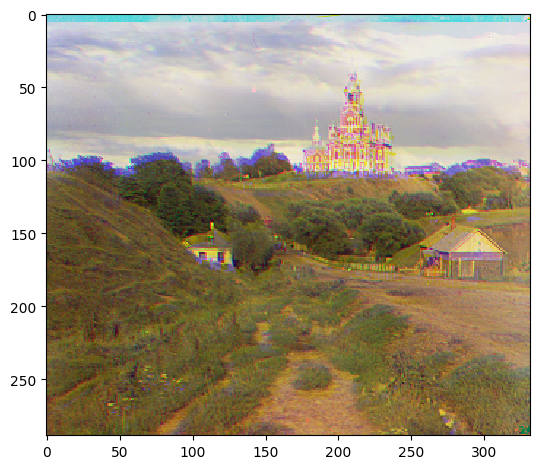

Image: church.tif
Displacement[[Green], [Red]]: [[0, 24], [0, 24]]


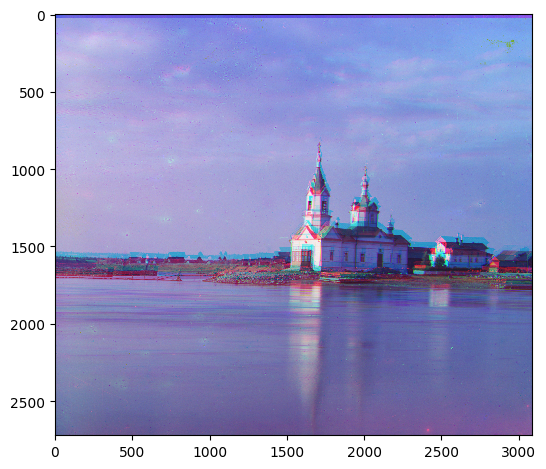

Image: emir.tif
Displacement[[Green], [Red]]: [[24, 48], [40, 104]]


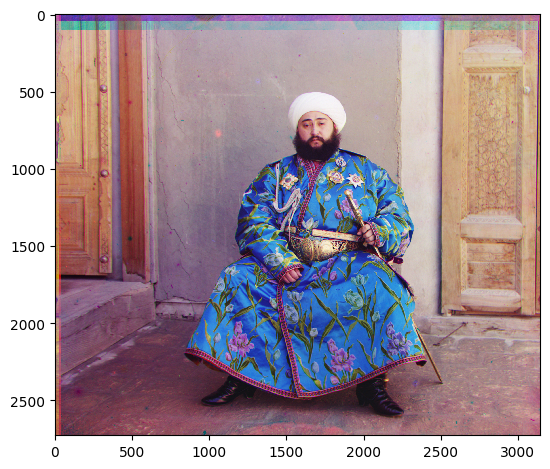

Image: harvesters.tif
Displacement[[Green], [Red]]: [[16, 60], [12, 124]]


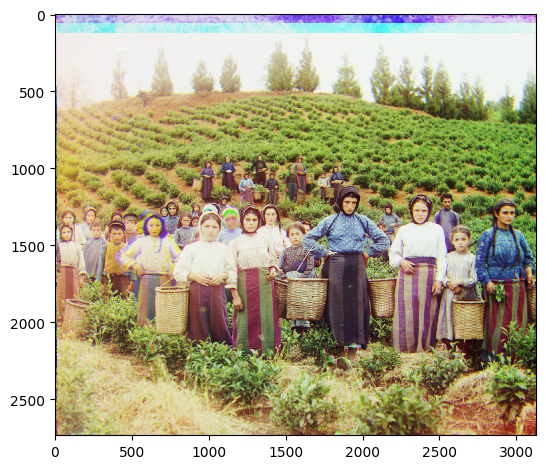

Image: icon.tif
Displacement[[Green], [Red]]: [[16, 44], [22, 92]]


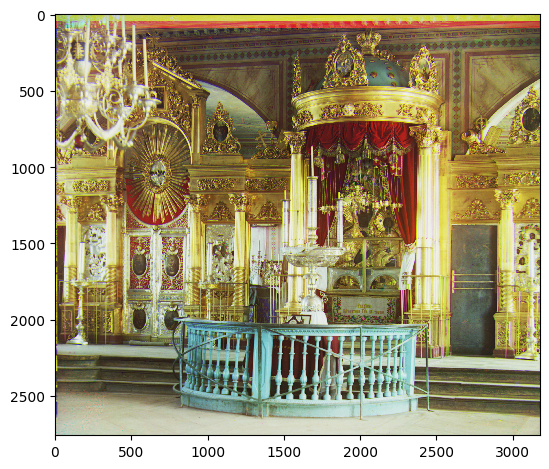

Image: lady.tif
Displacement[[Green], [Red]]: [[12, 48], [12, 112]]


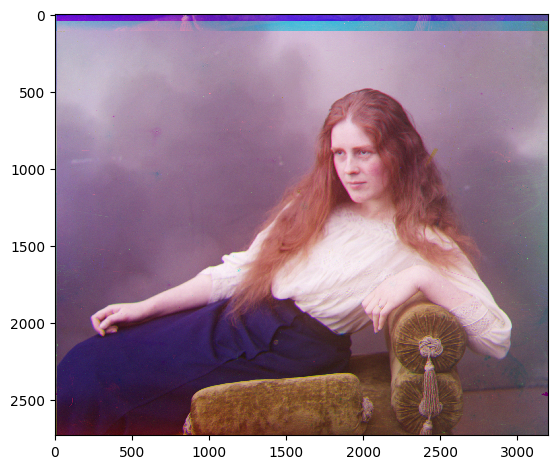

Image: melons.tif
Displacement[[Green], [Red]]: [[8, 80], [10, 176]]


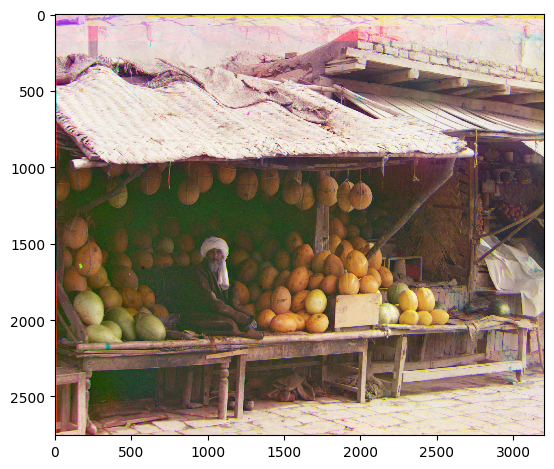

Image: monastery.jpg
Displacement[[Green], [Red]]: [[0, 0], [0, 6]]


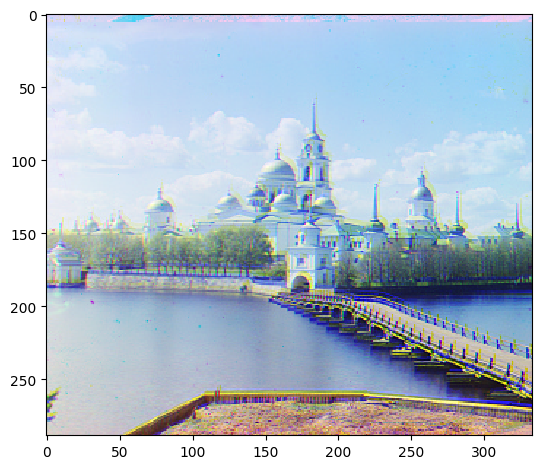

Image: onion_church.tif
Displacement[[Green], [Red]]: [[32, 48], [42, 104]]


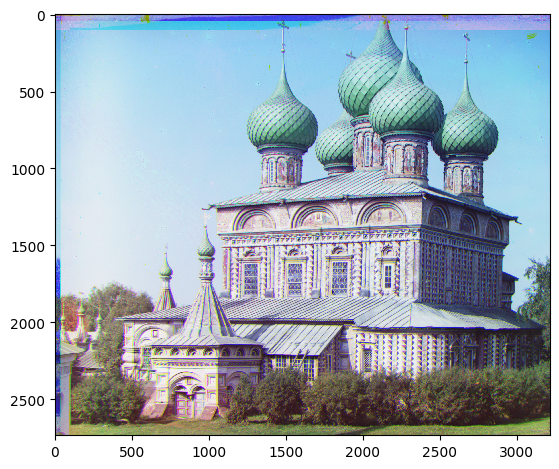

Image: sculpture.tif
Displacement[[Green], [Red]]: [[-10, 34], [-26, 140]]


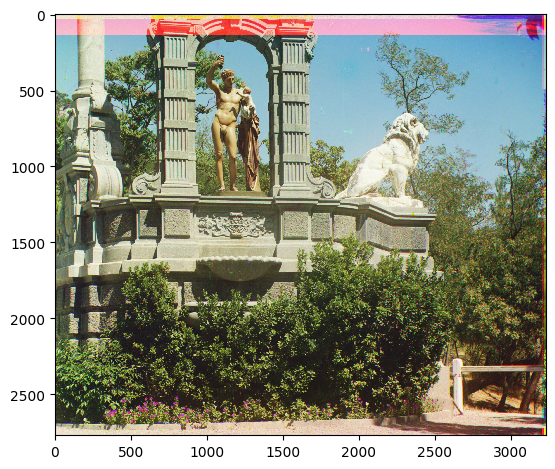

Image: self_portrait.tif
Displacement[[Green], [Red]]: [[24, 76], [32, 174]]


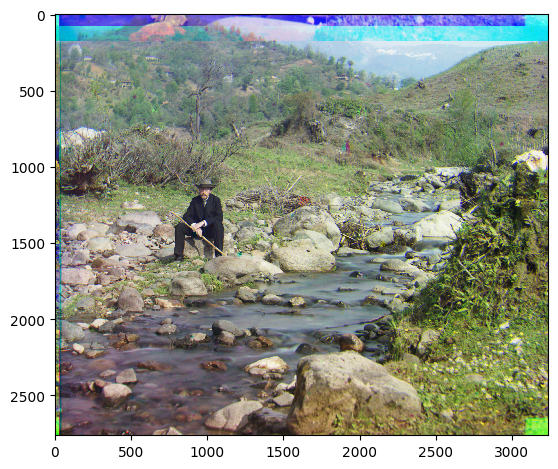

Image: three_generations.tif
Displacement[[Green], [Red]]: [[16, 54], [10, 114]]


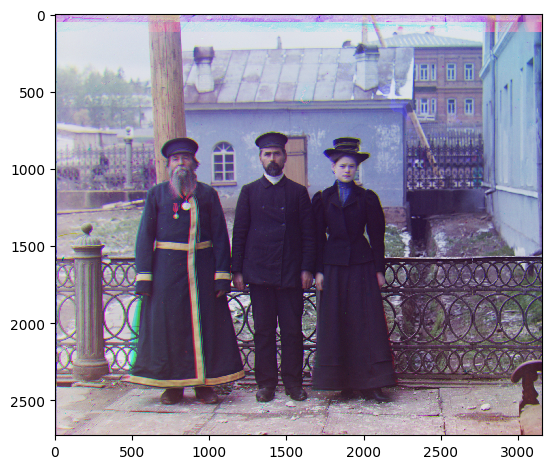

Image: tobolsk.jpg
Displacement[[Green], [Red]]: [[0, 2], [0, 6]]


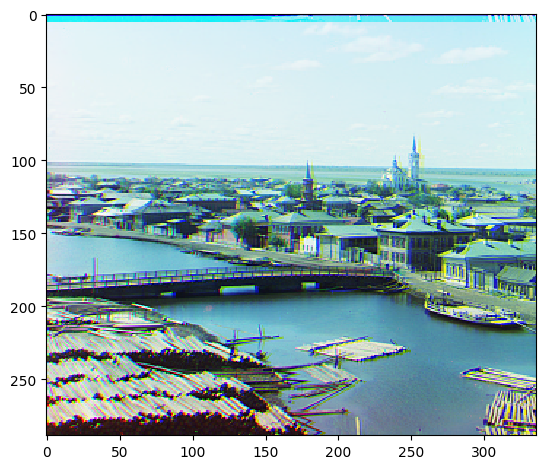

Image: train.tif
Displacement[[Green], [Red]]: [[6, 42], [30, 86]]


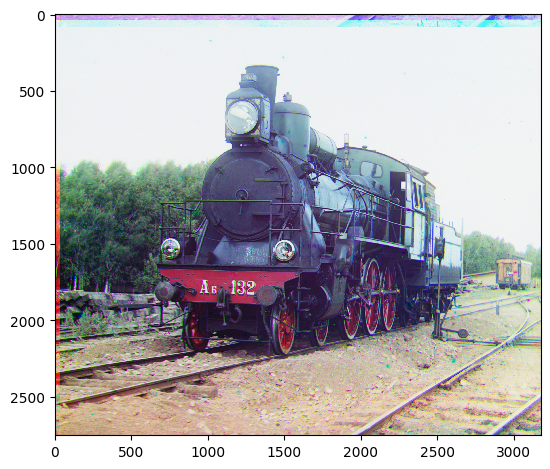

In [ ]:
# Path to the "original_data" folder, which contains the input images
img_dir = "/path/to/your/original_data"  # Replace with your actual filepath

# Accessing each of the images
files = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f))]

# Iterating through each of the images to colorize
for file in files:
    # Check if the file ends with ".tif" or ".jpg"
    if file.endswith(".tif") or file.endswith(".jpg"):
        colorize(os.path.join(img_dir, file))